# Advanced Model

In this lab we will study two other classification models: the **Random Forest** and **Gradient Boosting**. We expect both to give better results than the previous models. In addition, **random search** activities with **k-fold cross validation** will be performed for these two models to be able to find the best hyperparameters with which to train our models. These activities will be further refined with the use of a **grid search**, again with **k-fold cross validation**.  

Read these articles to learn more:  
1. https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85  
2. https://medium.datadriveninvestor.com/k-fold-cross-validation-6b8518070833

**Remeber**: in all tasks we will use a **random_state = \<SOME VALUE\>**!

In [1]:
import os 
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns

%matplotlib inline

Read CSVs files **data/tmp_train/tmp_train.csv** and **data/tmp_val/tmp_val.csv** from **S3 bucket** and prepare two dataframes: **train** and **test**. We will use them to train our models and to evaluate them.  
Display first rows of both and their shapes.

In [2]:
# LOCAL 
rs = 42
path_to_dataset = 'datasets/TRAIN_TO_SHARE.CSV'


dataset = pd.read_csv(path_to_dataset)
dataset.head()

,carat_class,cut,color,clarity,depth,table,price,x,y,z
0,low,Ideal,E,SI2,61.746807,54.657905,308.000982,5.087917,4.074514,2.640541
1,low,Premium,E,SI1,60.811398,61.500866,311.972787,4.935622,4.002951,2.566944
2,low,Good,E,VS1,57.463159,64.434528,306.322634,4.836103,3.966641,2.238341
3,low,Premium,I,VS2,62.110048,57.770527,308.236569,5.107297,3.941319,2.476921
4,low,Good,J,SI2,63.367713,58.202601,317.016683,5.348185,4.276069,2.899670


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43170 entries, 0 to 43169
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   carat_class  43170 non-null  object 
 1   cut          42311 non-null  object 
 2   color        41046 non-null  object 
 3   clarity      41871 non-null  object 
 4   depth        40582 non-null  float64
 5   table        42735 non-null  float64
 6   price        39527 non-null  float64
 7   x            43128 non-null  float64
 8   y            42615 non-null  float64
 9   z            42327 non-null  float64
dtypes: float64(6), object(4)
memory usage: 3.3+ MB


In [4]:
dataset['cut'] = dataset['cut'].astype('category')
dataset['color'] = dataset['color'].astype('category')
dataset['clarity'] = dataset['clarity'].astype('category')
dataset['carat_class'] = dataset['carat_class'].astype('category')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43170 entries, 0 to 43169
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   carat_class  43170 non-null  category
 1   cut          42311 non-null  category
 2   color        41046 non-null  category
 3   clarity      41871 non-null  category
 4   depth        40582 non-null  float64 
 5   table        42735 non-null  float64 
 6   price        39527 non-null  float64 
 7   x            43128 non-null  float64 
 8   y            42615 non-null  float64 
 9   z            42327 non-null  float64 
dtypes: category(4), float64(6)
memory usage: 2.1 MB


In [5]:
dataset.describe()

,depth,table,price,x,y,z
count,40582.000000,42735.000000,39527.000000,43128.000000,42615.000000,42327.000000
mean,61.750269,57.453911,3911.581104,6.730082,5.733144,3.538764
std,1.634396,2.255019,3974.925834,1.125322,1.125156,0.724071
min,43.158207,43.321167,306.322634,0.935423,-0.165995,-0.253948
25%,60.805377,55.888065,938.079683,5.703162,4.705580,2.917361
50%,61.807778,57.164165,2392.586880,6.684222,5.687529,3.499653
75%,62.738652,58.878595,5309.267548,7.546948,6.547369,4.057237
max,78.111790,94.856676,18819.121864,11.642644,10.542158,31.908393


In [6]:
print('The dataset has {} rows.'.format(dataset.shape[0]))
print('The dataset has {} duplicated rows.'.format(dataset.duplicated().sum()))

The dataset has 43170 rows.
The dataset has 0 duplicated rows.


In [7]:
dataset['carat_class'].value_counts()

low       25498
medium    15893
high       1779
Name: carat_class, dtype: int64

<Figure size 432x432 with 0 Axes>

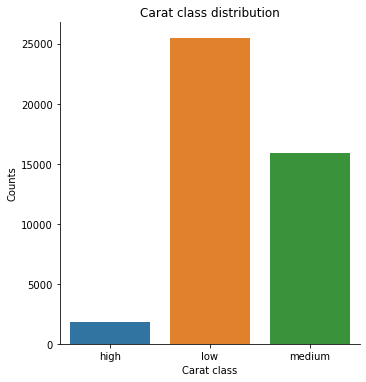

In [8]:
plt.figure(figsize=(6, 6))
fig = sns.catplot(x="carat_class", kind="count", data=dataset)
fig.set_axis_labels("Carat class", "Counts")
plt.title("Carat class distribution")
plt.show()

Pay attention, the carat_class is unbalanced so we have to consider to oversample or undersample the dataset

In [9]:
dataset['cut'].value_counts()

Ideal        16892
Premium      10771
Very Good     9508
Good          3885
Fair          1255
Name: cut, dtype: int64

In [10]:
dataset['color'].value_counts()

G    8472
E    7476
F    7305
H    6334
D    5167
I    4135
J    2157
Name: color, dtype: int64

In [11]:
dataset['clarity'].value_counts()

SI1     10105
VS2      9626
SI2      7108
VS1      6306
VVS2     3965
VVS1     2852
IF       1340
I1        569
Name: clarity, dtype: int64

In [12]:
dataset.isna().values.any()
print('Searching for null values...')
dataset.isna().sum(axis=0)

Searching for null values...


carat_class       0
cut             859
color          2124
clarity        1299
depth          2588
table           435
price          3643
x                42
y               555
z               843
dtype: int64

In [13]:
dataset.isna().mean(axis=0) * 100

carat_class    0.000000
cut            1.989808
color          4.920083
clarity        3.009034
depth          5.994904
table          1.007644
price          8.438731
x              0.097290
y              1.285615
z              1.952745
dtype: float64

<AxesSubplot:xlabel='index'>

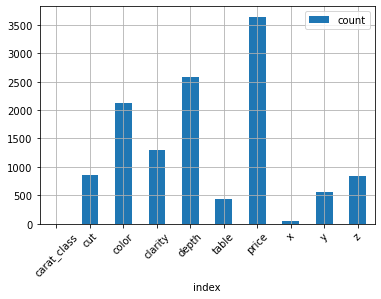

In [14]:
dataset.isna().sum().reset_index(name="count").plot.bar(x='index', y='count', rot=45, grid=True )

In [15]:
df = dataset.dropna().copy(deep=True)
size_before = len(dataset)
size_after = len(df)
print(f'The dataset contains {size_before} rows')
print(f'After dropping duplicates there are {size_after} rows ({size_after/size_before * 100:.02f}% left)')

The dataset contains 43170 rows
After dropping duplicates there are 32127 rows (74.42% left)


In [16]:
df['carat_class'].value_counts()

low       18987
medium    11824
high       1316
Name: carat_class, dtype: int64

<Figure size 432x432 with 0 Axes>

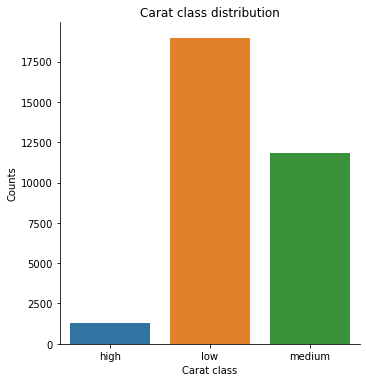

In [17]:
plt.figure(figsize=(6, 6))
fig = sns.catplot(x="carat_class", kind="count", data=df)
fig.set_axis_labels("Carat class", "Counts")
plt.title("Carat class distribution")
plt.show()

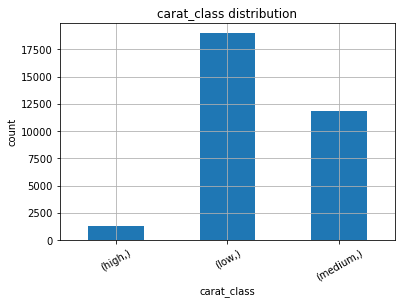

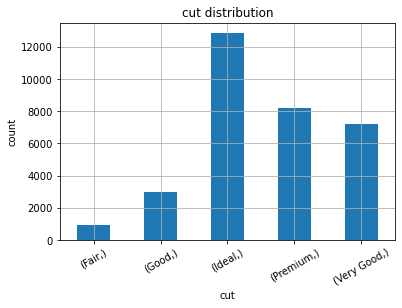

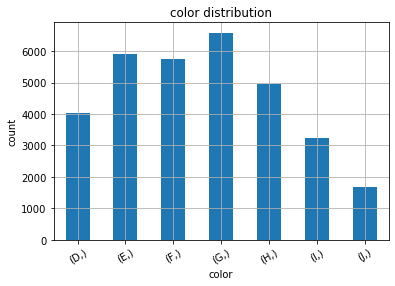

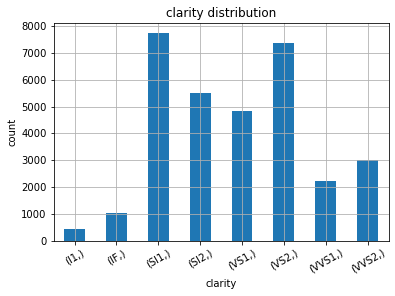

In [18]:
for col in df.columns:
    counts=df[[col]].value_counts(sort=False)
    if (df[col].dtype != float):
        counts.plot.bar(grid=True, rot=30, ylabel='count', title=col+' distribution')        
    plt.show()

In [19]:
def plotTriangularCorrelationMatrix(corr):
    plt.figure(figsize=(30, 15))
    # define the mask to set the values in the upper triangle to True
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

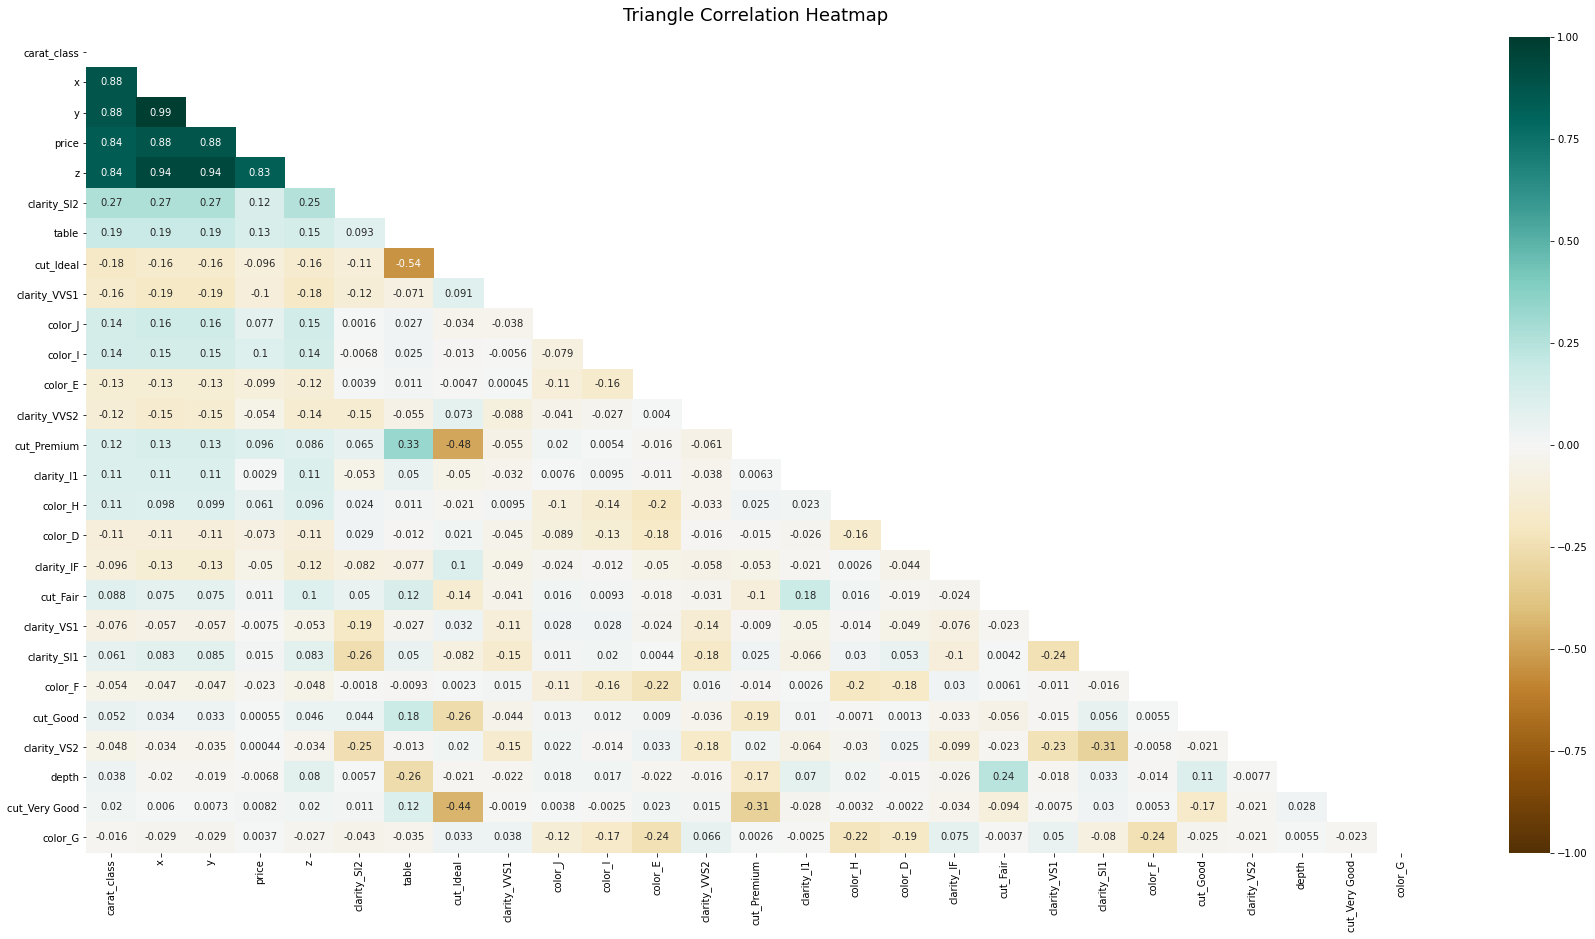

In [20]:
df_corr = df.copy(deep=True)
df_corr['carat_class'] = df_corr['carat_class'].map({'low':0, 'medium':1, 'high':2}).astype(float)
df_corr = pd.get_dummies(df_corr, columns=['cut','color','clarity'])
corr=df_corr.corr()
#

corr_cols = pd.DataFrame(abs(corr['carat_class']).sort_values(ascending=False)).reset_index()['index'].tolist() 
corr=df_corr[corr_cols].corr()
plotTriangularCorrelationMatrix(corr)

-----------------------------------------------------
	ANALYZE AND REMOVE OUTLIERS FROM depth
-----------------------------------------------------
NULL values:
0
Now the number of NULL values is:
0
Relevant statistical values:
count    32127.000000
mean        61.752713
std          1.629268
min         43.158207
25%         60.806255
50%         61.807980
75%         62.735808
max         77.667833
Name: depth, dtype: float64


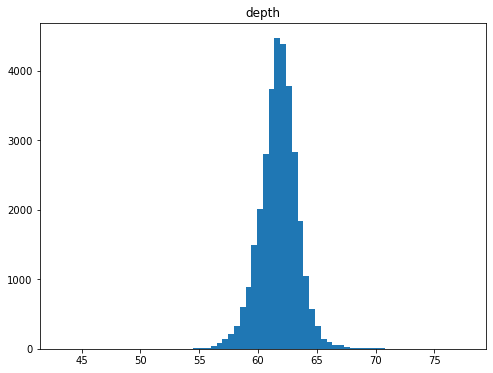

The IQR is:
1.9295529543454322
P90 is:
63.618944645659354
Number of outliers:
3213
Now the set of outliers is empty:
0
-----------------------------------------------------
	ANALYZE AND REMOVE OUTLIERS FROM table
-----------------------------------------------------
NULL values:
0
Now the number of NULL values is:
0
Relevant statistical values:
count    32127.000000
mean        57.446095
std          2.262754
min         43.321167
25%         55.876260
50%         57.162925
75%         58.874491
max         94.856676
Name: table, dtype: float64


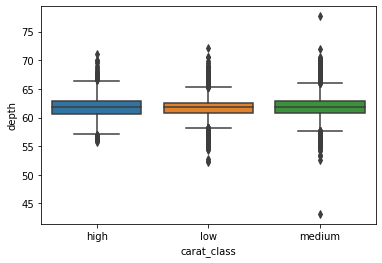

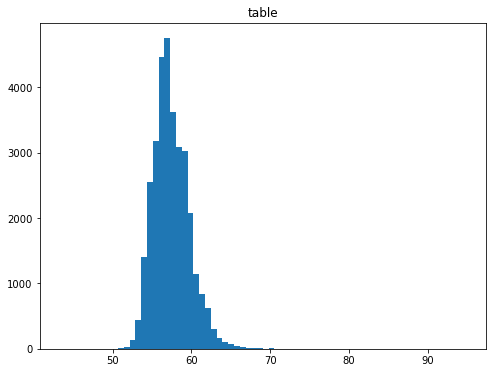

The IQR is:
2.9982311563258364
P90 is:
60.31023171264552
Number of outliers:
3213
Now the set of outliers is empty:
0
-----------------------------------------------------
	ANALYZE AND REMOVE OUTLIERS FROM price
-----------------------------------------------------
NULL values:
0
Now the number of NULL values is:
0
Relevant statistical values:
count    32127.000000
mean      3904.091678
std       3965.745236
min        306.322634
25%        939.087378
50%       2395.817454
75%       5283.849782
max      18819.121864
Name: price, dtype: float64


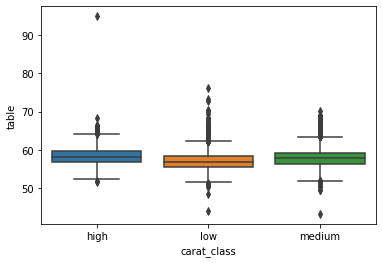

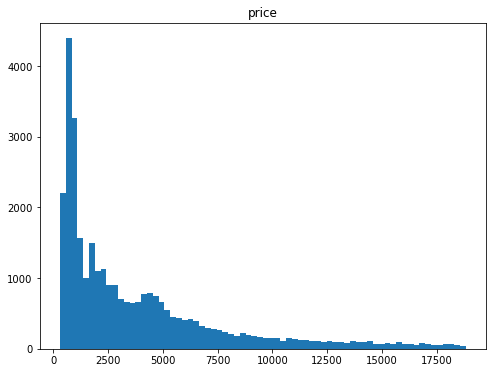

The IQR is:
4344.762403569417
P90 is:
9665.819756301418
Number of outliers:
3213
Now the set of outliers is empty:
0
-----------------------------------------------------
	ANALYZE AND REMOVE OUTLIERS FROM x
-----------------------------------------------------
NULL values:
0
Now the number of NULL values is:
0
Relevant statistical values:
count    32127.000000
mean         6.728623
std          1.122789
min          0.935423
25%          5.705436
50%          6.689311
75%          7.545650
max         11.205098
Name: x, dtype: float64


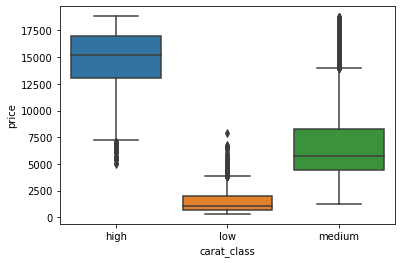

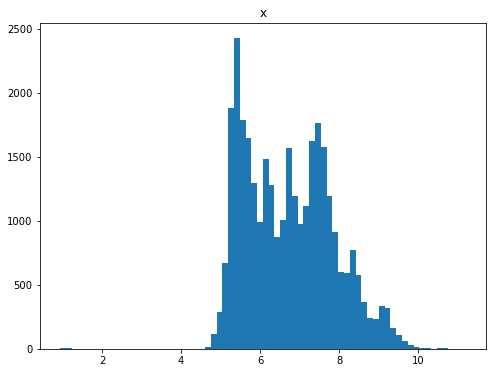

The IQR is:
1.8402139253466157
P90 is:
8.279235108458636
Number of outliers:
3213
Now the set of outliers is empty:
0
-----------------------------------------------------
	ANALYZE AND REMOVE OUTLIERS FROM y
-----------------------------------------------------
NULL values:
0
Now the number of NULL values is:
0
Relevant statistical values:
count    32127.000000
mean         5.731106
std          1.122296
min         -0.165995
25%          4.707500
50%          5.688888
75%          6.544295
max         10.359881
Name: y, dtype: float64


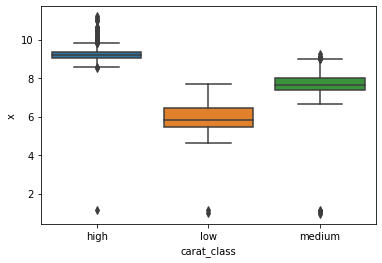

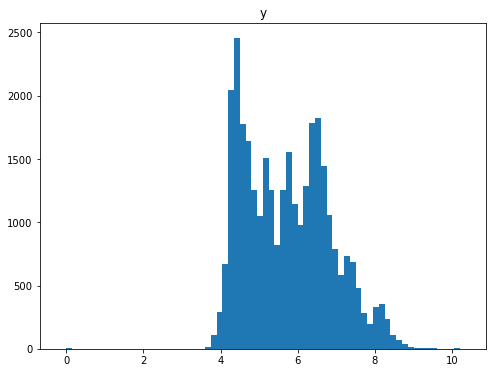

The IQR is:
1.836795375931576
P90 is:
7.274324902875422
Number of outliers:
3213
Now the set of outliers is empty:
0
-----------------------------------------------------
	ANALYZE AND REMOVE OUTLIERS FROM z
-----------------------------------------------------
NULL values:
0
Now the number of NULL values is:
0
Relevant statistical values:
count    32127.000000
mean         3.538347
std          0.726126
min         -0.253948
25%          2.919690
50%          3.500981
75%          4.053829
max         31.908393
Name: z, dtype: float64


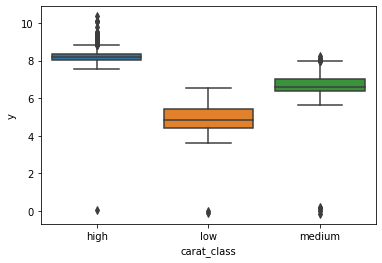

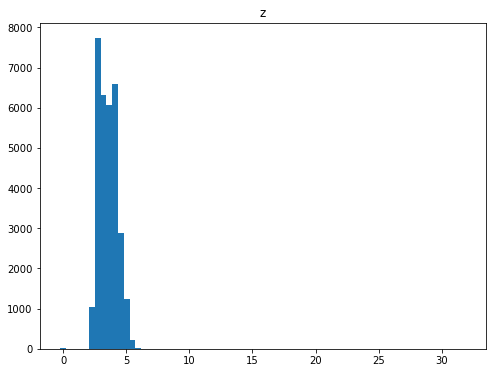

The IQR is:
1.1341387787070825
P90 is:
4.485139600889474
Number of outliers:
3213
Now the set of outliers is empty:
0


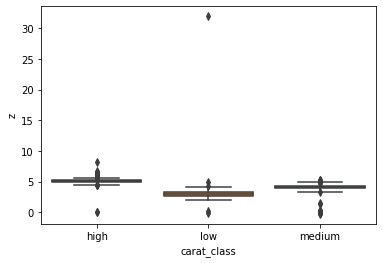

In [21]:
for column in df.columns:
    if (df[column].dtype != float):
        continue
    print('-----------------------------------------------------')
    print(f'\tANALYZE AND REMOVE OUTLIERS FROM {column}')
    print('-----------------------------------------------------')

    print('NULL values:')
    print(df[column].isnull().sum())
    df[column] = df[column].fillna(df[column].mean())
    print('Now the number of NULL values is:')
    print(df[column].isnull().sum())
    print('Relevant statistical values:')
    print(df[column].describe())
    plt.figure(figsize=(8, 6))
    plt.hist(df[column].values, bins=70, density=False)
    plt.title("{}".format(column));
    plt.show()
    sns.boxplot(x='carat_class', y=column, data=df)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    print('The IQR is:')
    print(IQR)

    P90 = df[column].quantile(0.90)
    print('P90 is:')
    print(P90)

    df_out = df[df[column] > P90]
    print('Number of outliers:')
    print(df_out[column].count())

    df[column] = df[column].apply(lambda x: P90 if (x > P90) else x)
    df_out = df[df[column] > P90]
    print('Now the set of outliers is empty:')
    print(df_out[column].count())